# U-Net Model for Segmenting Breast Ultrasound Images in Tumour Detection

The following Jupyter Notebook uses the PyTorch machine learning framework to train and test on a U-Net model built from the ground up.

The dataset used consists of images from breast ultrasound scans that are categorized into two classes depending on the tumour (or lack thereof): normal, benign, and malignant.

However, as you will notice during the data preparation segment, we will not be making use of the normal images. The model will be trained on benign and malignant classes only.

Each ultrasound scan contains a mask image that segment where the tumour is.

The goal of the model is, given an ultrasound image, be able to segment the location of the tumour and return a mask.

The Notebook is divided as follows:

* Data preparation

* Creating the custom Dataset and U-Net model

* Create helper functions such as saving/loading the model, fetch DataLoader's and so on. 

* Set the hyperparameters, transforms, and training loop function.

* Instantiate and train the model with our `main()` function.

* Evaluate and output performance

* Save the model

**Note**: This follows the same pattern and logic as the repository by Aladdin Persson, seen here: https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet


## How to run

1. Click on `Runtime` from the bar above.
2. Click on `change runtime type`.
3. Select `GPU` as your hardware accelerator and save.
4. Connect to a runtime by clicking on `Connect` in the top right-hand side.
5. Click on `Runtime` again and `Run all`.

## If you are using a pre-trained model please [go here](#scrollTo=ANNsD_rGKtfF&line=7&uniqifier=1).

## Data preparation

Importing all necessary libraries.

In [ ]:
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms.functional as TF
import pandas as pd
import torchvision
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import requests
import os
import shutil
import random
import glob
import pandas as pd
from typing import Dict, List
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import gc
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

In [ ]:
gc.collect()
torch.cuda.empty_cache()

Download data zip file.

In [ ]:
# gdown allows downloading large files from Google Drive by passing id
!gdown 1LljpoDlVfLoowaG6qAq_rCzX7W6wVjql

Downloading...
From: https://drive.google.com/uc?id=1LljpoDlVfLoowaG6qAq_rCzX7W6wVjql
To: /content/data.zip
100% 204M/204M [00:09<00:00, 21.7MB/s]


Create `data` directory and unzip contents.

In [ ]:
data_path = 'data'

if os.path.isdir(data_path):
  print("The directory already exists.")
else:
    with zipfile.ZipFile("data.zip", "r") as zip_ref:
      zip_ref.extractall("data")

The following three cells perform a similar data preperation logic.

The first is for normal scans and masks, the second for benign, and third for malignant.

* Sets paths for training and testing folders.
* Create ratio that will be used to split training and testing data.
* Fetches all the images for the specified class and shuffles them.
* Splits the images into train and test sets.
* Create the directories where we will be storing them.
* Move the train and test data to the train and test directories, respectively.

In [ ]:
path_to_normal = 'data/ultrasound/normal'

if os.path.exists(path_to_normal):
  
  # set the path to the output folders for the train and test data
  train_normal = 'data/train/normal'
  test_normal = 'data/test/normal'

  # set the train/test split ratio
  train_ratio = 0.70

  # get a list of all image file names in the folder
  normal_image_filenames = os.listdir(path_to_normal)

  data = []

  for image in normal_image_filenames:
    if 'mask' not in image:
      ultrasound_image = image
      mask_image = image.replace(')', ')_mask')
      data.append((ultrasound_image, mask_image))

  random.shuffle(data)

  # split the image filenames into train and test sets
  split_index = int(train_ratio * len(data))
  train_image_filenames = data[:split_index]
  test_image_filenames = data[split_index:]

  # create the train and test output folders if they don't already exist
  if not os.path.exists(train_normal):
    os.makedirs(train_normal)
  if not os.path.exists(test_normal):
    os.makedirs(test_normal)

  # copy the train images to the train output folder
  for ultrasound_image, mask_image in train_image_filenames:
    shutil.copy(os.path.join(path_to_normal, ultrasound_image), os.path.join(train_normal, ultrasound_image)) # copy the ultrasound image to the training normal directory
    shutil.copy(os.path.join(path_to_normal, mask_image), os.path.join(train_normal, mask_image)) # copy the mask image to the training normal directory


  # copy the test images to the test output folder
  for  ultrasound_image, mask_image in test_image_filenames:
    shutil.copy(os.path.join(path_to_normal, ultrasound_image), os.path.join(test_normal, ultrasound_image)) # copy the ultrasound image to the testing normal directory
    shutil.copy(os.path.join(path_to_normal, mask_image), os.path.join(test_normal, mask_image)) # copy the mask image to the testing normal directory


  print(f"Finished splitting {len(normal_image_filenames)} images into train and test sets.")

Finished splitting 266 images into train and test sets.


In [ ]:
path_to_benign = 'data/ultrasound/benign'

if os.path.exists(path_to_benign):
  
  # set the path to the output folders for the train and test data
  train_benign = 'data/train/benign'
  test_benign = 'data/test/benign'

  # set the train/test split ratio
  train_ratio = 0.70

  # get a list of all image file names in the folder
  benign_image_filenames = os.listdir(path_to_benign)

  data = []

  for image in benign_image_filenames:
    if 'mask' not in image:
      ultrasound_image = image
      mask_image = image.replace(')', ')_mask')
      data.append((ultrasound_image, mask_image))

  random.shuffle(data)

  # split the image filenames into train and test sets
  split_index = int(train_ratio * len(data))
  train_image_filenames = data[:split_index]
  test_image_filenames = data[split_index:]

  # create the train and test output folders if they don't already exist
  if not os.path.exists(train_benign):
    os.makedirs(train_benign)
  if not os.path.exists(test_benign):
    os.makedirs(test_benign)

  # copy the train images to the train output folder
  for ultrasound_image, mask_image in train_image_filenames:
    shutil.copy(os.path.join(path_to_benign, ultrasound_image), os.path.join(train_benign, ultrasound_image)) # copy the ultrasound image to the training benign directory
    shutil.copy(os.path.join(path_to_benign, mask_image), os.path.join(train_benign, mask_image)) # copy the mask image to the training benign directory


  # copy the test images to the test output folder
  for  ultrasound_image, mask_image in test_image_filenames:
    shutil.copy(os.path.join(path_to_benign, ultrasound_image), os.path.join(test_benign, ultrasound_image)) # copy the ultrasound image to the testing benign directory
    shutil.copy(os.path.join(path_to_benign, mask_image), os.path.join(test_benign, mask_image)) # copy the mask image to the testing benign directory


  print(f"Finished splitting {len(benign_image_filenames)} images into train and test sets.")

Finished splitting 891 images into train and test sets.


In [ ]:
path_to_malignant = 'data/ultrasound/malignant'

if os.path.exists(path_to_malignant):
  
  # set the path to the output folders for the train and test data
  train_malignant = 'data/train/malignant'
  test_malignant = 'data/test/malignant'

  # set the train/test split ratio
  train_ratio = 0.70

  # get a list of all image file names in the folder
  malignant_image_filenames = os.listdir(path_to_malignant)

  data = []

  for image in malignant_image_filenames:
    if 'mask' not in image:
      ultrasound_image = image
      mask_image = image.replace(')', ')_mask')
      data.append((ultrasound_image, mask_image))

  random.shuffle(data)

  # split the image filenames into train and test sets
  split_index = int(train_ratio * len(data))
  train_image_filenames = data[:split_index]
  test_image_filenames = data[split_index:]

  # create the train and test output folders if they don't already exist
  if not os.path.exists(train_malignant):
    os.makedirs(train_malignant)
  if not os.path.exists(test_malignant):
    os.makedirs(test_malignant)

  # copy the train images to the train output folder
  for ultrasound_image, mask_image in train_image_filenames:
    shutil.copy(os.path.join(path_to_malignant, ultrasound_image), os.path.join(train_malignant, ultrasound_image)) # copy the ultrasound image to the training malignant directory
    shutil.copy(os.path.join(path_to_malignant, mask_image), os.path.join(train_malignant, mask_image)) # copy the mask image to the training malignant directory


  # copy the test images to the test output folder
  for  ultrasound_image, mask_image in test_image_filenames:
    shutil.copy(os.path.join(path_to_malignant, ultrasound_image), os.path.join(test_malignant, ultrasound_image)) # copy the ultrasound image to the testing malignant directory
    shutil.copy(os.path.join(path_to_malignant, mask_image), os.path.join(test_malignant, mask_image)) # copy the mask image to the testing malignant directory


  print(f"Finished splitting {len(malignant_image_filenames)} images into train and test sets.")

Finished splitting 421 images into train and test sets.


In [ ]:
# moving ultrasound dir out of 'data/' path
check_dir = 'ultrasound'

if os.path.isdir(check_dir):
  print('Dataset already moved.')
else:
  root = '/content'
  dataset = 'data/ultrasound'
  shutil.move(dataset, root)

Loop through both directories we created above, and remove either the ultrasound image or mask image.

Creating a path to the training images and masks, and testing images and masks.

Note that we also exclude all normal images as we will be focusing on benign and malignant alone.

In [ ]:
path_to_images, path_to_masks = [], []

for directory_path, directory_names, file_names in os.walk('data/train'):
    # loop through all image files in the current directory
    for file_name in file_names:
        if "mask" not in file_name and "normal" not in file_name:
            # add the file if it does not contains "mask" in its filename
            path_to_images.append(os.path.join(directory_path, file_name))

for directory_path, directory_names, file_names in os.walk('data/train'):
    # loop through all image files in the current directory
    for file_name in file_names:
        if "mask" in file_name and "normal" not in file_name:
            # add the file if it does contains "mask" in its filename
            path_to_masks.append(os.path.join(directory_path, file_name))

In [ ]:
path_to_images_test, path_to_masks_test = [], []

for directory_path, directory_names, file_names in os.walk('data/test'):
    # loop through all image files in the current directory
    for file_name in file_names:
        if "mask" not in file_name and "normal" not in file_name:
            # add the file if it does not contains "mask" in its filename
            path_to_images_test.append(os.path.join(directory_path, file_name))

for directory_path, directory_names, file_names in os.walk('data/test'):
    # loop through all image files in the current directory
    for file_name in file_names:
        if "mask" in file_name and "normal" not in file_name:
            # add the file if it does contains "mask" in its filename
            path_to_masks_test.append(os.path.join(directory_path, file_name))

## Creating our Dataset class and U-Net model

In [ ]:
class UltrasoundDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = image_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):

        img_path = self.images[index]
        
        # getting mask path
        c = self.getClass(image_path=img_path)
        number_of_data = int(''.join(filter(str.isdigit, img_path)))
        result = [i for i in self.mask_dir if c in i and '(' + str(number_of_data) + ')' in i]
        mask_path = result[0]

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

    def getClass(self, image_path):

      if 'normal' in image_path:
        c = 'normal'
      elif 'benign' in image_path:
        c = 'benign'
      elif 'malignant' in image_path:
        c = 'malignant'

      return c

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
# quick test on our model to check all is working well
def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape

test()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Creating our helper functions

These include:

* `save_checkpoint` - Will save a copy of the model with all its weights and biases / state dict.

* `load_checkpoint` - Loads a given model.

* `get_loaders` - Creates the Dataset and DataLoader for our training set and testing/validation set.

* `check_accuracy` - Tests on the current state of the model given a DataLoader and prints an accuracy metric and a Dice score.

In [ ]:
def save_checkpoint(state, filename="UNET_model.pth"):
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = UltrasoundDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = UltrasoundDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

## Setting our training loop, transforms, hyperparameters, and other variables

In [ ]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 1
NUM_EPOCHS = 20
NUM_WORKERS = 2
IMAGE_HEIGHT = 600 
IMAGE_WIDTH = 700
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = path_to_images
TRAIN_MASK_DIR = path_to_masks
VAL_IMG_DIR = path_to_images_test
VAL_MASK_DIR = path_to_masks_test

train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

def train_fn(loader, model, optimizer, loss_fn, scaler):
    # loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loader):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward pass
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        # loop.set_postfix(loss=loss.item())

## Train our model

`main()` function will bring together all the pieces.

* Create model, loss function, optimizer, and scaler.

* Set up our DataLoader's.

* Train depending on `NUM_EPOCHS` set above.

In [ ]:
def main():
    
    # instantiate our model, loss function, and optimizer
    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler()

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY
    )

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    filename = "UNET_model_" + str(NUM_EPOCHS) + "_epochs" + ".pth"
    save_checkpoint(checkpoint, filename)

In [ ]:
main()

Got 74479744/81900000 with acc 90.94
Dice score: 0.29024380445480347
Got 75061930/81900000 with acc 91.65
Dice score: 0.3741484582424164
Got 75026172/81900000 with acc 91.61
Dice score: 0.45541173219680786
Got 75534303/81900000 with acc 92.23
Dice score: 0.4518227279186249
Got 75209702/81900000 with acc 91.83
Dice score: 0.48246774077415466
Got 75347925/81900000 with acc 92.00
Dice score: 0.4197642207145691
Got 74990382/81900000 with acc 91.56
Dice score: 0.40642890334129333
Got 75152783/81900000 with acc 91.76
Dice score: 0.39911720156669617
Got 74384276/81900000 with acc 90.82
Dice score: 0.42660290002822876
Got 75314094/81900000 with acc 91.96
Dice score: 0.3994867205619812
Got 75113996/81900000 with acc 91.71
Dice score: 0.4288794994354248
Got 75114232/81900000 with acc 91.71
Dice score: 0.3676348030567169
Got 75060545/81900000 with acc 91.65
Dice score: 0.4284208118915558
Got 75281672/81900000 with acc 91.92
Dice score: 0.42935454845428467
Got 75023859/81900000 with acc 91.60
Dice

## Evaluation

We will create a `saved_images` directory to store our predictions along with their ground truths and ultrasound scans.

In [ ]:
if not os.path.exists('saved_images'):
  os.makedirs('saved_images')

Create the validation DataLoader again

In [ ]:
val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_ds = UltrasoundDataset(
        image_dir=VAL_IMG_DIR,
        mask_dir=VAL_MASK_DIR,
        transform=val_transforms,
    )

val_loader = DataLoader(
        val_ds,
        batch_size=1,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=False,
    )

Create a new instance of the model and load the saved model's weights and biases.

In [ ]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
filename = "UNET_model_" + str(NUM_EPOCHS) + "_epochs" + ".pth"
load_checkpoint(torch.load(filename), model)

The following function will take a DataLoader, a model, and a destination path and perform forward passes on the model.

The feature (ultrasound image), the label (mask), and the output (predicted mask) are all stored in the given directory.


In [ ]:
def save_predictions_as_imgs(loader, model, folder="saved_images", device="cuda"):

    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(x, f"{folder}/ultrasound_{idx}.png")
        torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.png")
        torchvision.utils.save_image(y, f"{folder}/mask_{idx}.png")

In [ ]:
save_predictions_as_imgs(val_loader, model, "saved_images/", DEVICE)

After saving all our predictions, the `display_predictions()` funtion will display the ultrasound images, ground truth masks, and the predicted segmentations from the model.

In [ ]:
def display_predictions(folder="saved_images/", n=10):

  ultrasound_files = []
  ground_truth_files = []
  pred_images = []

  for files in os.listdir(folder):
    # loop through all files in the directory
    if "mask" in files:
        # add the file if it does not contains "mask" in its filename
        ground_truth_files.append(os.path.join(folder, files))
    elif "ultrasound" in files:
      # add the file if it contains "ultrasound" in its filename
      ultrasound_files.append(os.path.join(folder, files))
    else:
      # else it's a prediction
      pred_images.append(os.path.join(folder, files))
  
  random_ground_truth_files = random.sample(ground_truth_files, n)

  fig, ax = plt.subplots(n, 3, figsize=(15, 30))

  for idx, ground_truth_image in enumerate(random_ground_truth_files):

    if idx == 0:
      ax[idx, 0].set_title("Ultrasound image")
      ax[idx, 1].set_title("Ground truth mask")
      ax[idx, 2].set_title("Predicted mask")

    # fetch the index for the current example we're looking at
    ground_truth_image_number = ground_truth_image.split('/')[1].split('_')[1]

    # fetch the ultrasound image for the corresponding index above
    ultrasound_image = [i for i in ultrasound_files if ground_truth_image_number in i]
    ultrasound_image = ultrasound_image[0]

    # fetch the pred image for the corresponding index above
    pred_image = [i for i in pred_images if ground_truth_image_number in i]
    pred_image = pred_image[0]

    ultrasound_image = Image.open(ultrasound_image)
    ground_truth_image = Image.open(ground_truth_image)
    pred_image = Image.open(pred_image)

    ax[idx, 0].imshow(ultrasound_image)
    ax[idx, 0].axis(False)

    ax[idx, 1].imshow(ground_truth_image)
    ax[idx, 1].axis(False)

    ax[idx, 2].imshow(pred_image)
    ax[idx, 2].axis(False)


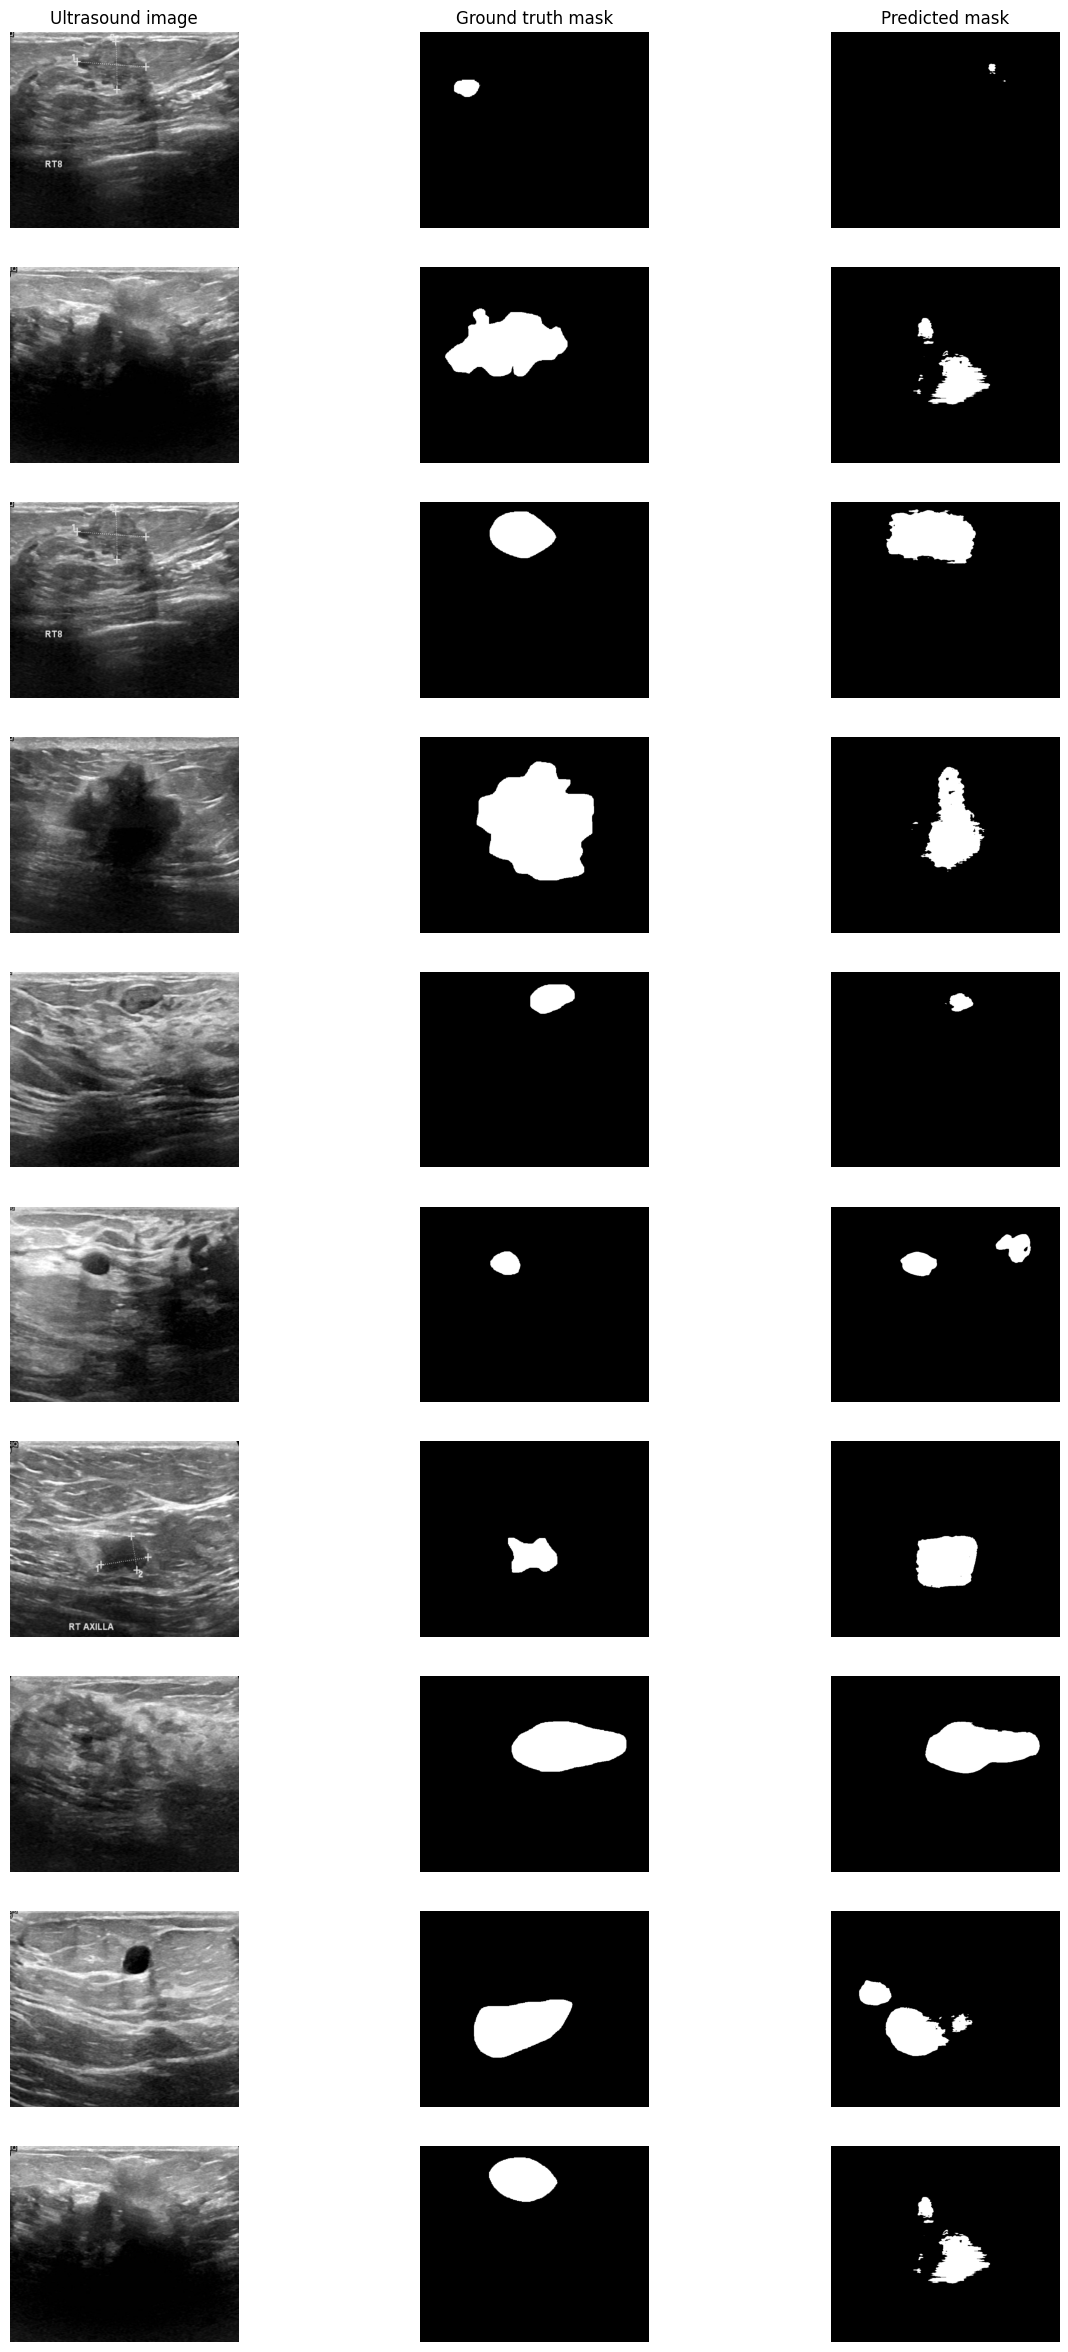

In [ ]:
display_predictions(n=10)

## Using our model to predict on a custom image

In [ ]:
import requests
from io import BytesIO

# fetch custom image 
response = requests.get('https://www.caperay.com/blog/wp-content/uploads/2021/01/Mehta_Clinical_Imaging_2021_Fig_4a-300x267.jpg')
img = Image.open(BytesIO(response.content))

In [ ]:
# converting the PIL image to a tensor
tensor_uint8 = torchvision.transforms.functional.pil_to_tensor(img)
tensor_uint8 = tensor_uint8[:3, :, :]

# converting our image to torch.float32 AND dividing by 255 to make all our values range from 0 to 1
custom_image = tensor_uint8.type(torch.float32) / 255.

In [ ]:
# resize image using transform
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(IMAGE_HEIGHT, IMAGE_WIDTH))
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 267, 300])
Transformed shape: torch.Size([3, 600, 700])


In [ ]:
# add a batch size
custom_image_transformed = custom_image_transformed.unsqueeze(0)

In [ ]:
# forward pass on model

model.eval()
with torch.no_grad():
  custom_image_pred = torch.sigmoid(model(custom_image_transformed.to(DEVICE)))
  custom_image_pred = (custom_image_pred > 0.5).float()

(-0.5, 699.5, 599.5, -0.5)

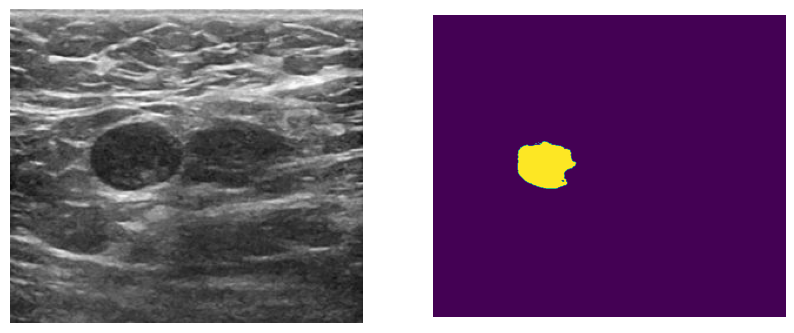

In [ ]:
# display ultrasound scan with predicted segmented mask

imagePIL = torchvision.transforms.ToPILImage()(custom_image_pred.squeeze(0))

ultrasound_image = img
mask_image = imagePIL

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(ultrasound_image)
ax[0].axis(False)

ax[1].imshow(imagePIL)
ax[1].axis(False)

## Using a pre-trained model

If you would like to use a pre-trained model instead of training one, then please follow the steps:

* Copy the model's `.pth` file to Google Colab's root files directory.

* After it has finished uploading, run the [Data preparation](#scrollTo=25MmDeuMf_bp) code cells to import all required libraries and set up the data properly.

* Then, go to the [model definition here](#scrollTo=1kB7k7IHmdXK&line=29&uniqifier=1) and run to set up the model.

* Afterwards, set the `LOAD_MODEL` bool below to true and run the code cell to load the model.

* When the model has finished loading, run the cells within the following code blocks:

  * [Creating our Dataset class and U-Net model](#scrollTo=C9Ee5NV54Dmj)
  * [Creating our helper functions](#scrollTo=t1sOBMiEIYXr)
  * [Setting our training loop, transforms, hyperparameters, and other variables](#scrollTo=2EDLbuzSKrDm)
  * [Evaluation](#scrollTo=scX4uPXtN76y)

In [ ]:
LOAD_MODEL = False

def load_checkpoint(checkpoint, model):
    model.load_state_dict(checkpoint["state_dict"])

if LOAD_MODEL:
  model = UNET(in_channels=3, out_channels=1).to(DEVICE)
  filename = "MyUNet_Model.pth"
  load_checkpoint(torch.load(filename), model)